# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects _on top_ of existing visibility simulations, it also provides a neat interface to several visibility simulators.

It does so through the base class ``VisibilitySimulator``, which sets a standard API from which all simulators must derive.

## VisCPU

In [1]:
from hera_sim.visibilities import VisCPU, HealVis
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import itertools
import copy
from pyuvsim.analyticbeam import AnalyticBeam
from astropy.units import sday

import healvis as HEALVIS

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/jackson/hera/hera_sim/hera_sim/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


In [2]:
### np.unique can reorder elements
def unique(arr):
    arr = np.array(arr)
    indices = np.unique(arr, return_index=True)[1]
    return np.array([arr.flatten()[i] for i in sorted(indices)])

def plot_blts(simulator):
    fig, ax = plt.subplots(2, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"}, figsize=(16,8))
    
    fig.suptitle(type(simulator).__name__, fontweight='bold')
    
    lw = 2
    
    for i in simulator.uvdata.antenna_numbers:
        auto_ind = simulator.uvdata.antpair2ind((i,i))
        #ax[0].plot(unique(simulator.uvdata.lst_array)*12/np.pi, 
        #   simulator.uvdata.data_array[auto_ind, 0, 0, 0], label="ant_{}".format(i))
        
        ax[0].plot(np.real(simulator.uvdata.data_array[auto_ind, 0, 0, 0]), label="ant_{} real".format(i), linewidth=lw)
        ax[0].plot(np.imag(simulator.uvdata.data_array[auto_ind, 0, 0, 0]), linestyle="--", label="ant_{} imag".format(i), linewidth=lw)

        for j in simulator.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator.uvdata.antpair2ind((i,j))
            #ax[1].plot(unique(simulator.uvdata.lst_array)*12/np.pi, simulator.uvdata.data_array[cross_ind, 0, 0, 0], label="bl({},{})".format(i,j))
            ax[1].plot(np.real(simulator.uvdata.data_array[cross_ind, 0, 0, 0]), label="bl({},{}) real".format(i,j), linewidth=lw)
            ax[1].plot(np.imag(simulator.uvdata.data_array[cross_ind, 0, 0, 0]), linestyle="--", label="bl({},{}) imag".format(i,j), linewidth=lw)
            
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[1].set_xlabel("Observation Number")

def compare_blts(simulator1, simulator2):
    fig, ax = plt.subplots(3, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"}, figsize=(16, 12))
    
    name1 = type(simulator1).__name__
    name2 = type(simulator2).__name__
    
    fig.suptitle(name1 + " vs " + name2, fontweight='bold')
    
    lw=3

    for i in simulator1.uvdata.antenna_numbers:
        auto_ind = simulator1.uvdata.antpair2ind((i,i))
        auto1 = np.real(simulator1.uvdata.data_array[auto_ind, 0, 0, 0])
        auto2 = np.real(simulator2.uvdata.data_array[auto_ind, 0, 0, 0])
                        
        ax[0].plot(auto1, label=("ant_{} " + name1).format(i), linewidth=lw)
        ax[0].plot(auto2, linestyle="--", label=("ant_{} "+name2).format(i), linewidth=lw)

        for j in simulator1.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator1.uvdata.antpair2ind((i,j))
            cross1 = np.real(simulator1.uvdata.data_array[cross_ind, 0, 0, 0])
            cross2 = np.real(simulator2.uvdata.data_array[cross_ind, 0, 0, 0])
                        
            ax[1].plot(cross1, label=("bl({},{}) " + name1).format(i,j), linewidth=lw)
            ax[1].plot(cross2, linestyle="--", label=("bl({},{}) " + name2).format(i,j), linewidth=lw)
            ax[2].plot(cross2 - cross1, label=("bl({},{}) " + "Difference").format(i,j), linewidth=lw, c="k")
    
    [a.legend() for a in ax]
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[2].set_title(name2 + " Cross-Correlation minus " + name1 + " Cross-Correlation")
    ax[1].set_xlabel("Observation Number")

``VisCPU`` natively deals with diffuse emission, and the ``VisibilitySimulator`` uses ``healpix`` maps to represent such emission:

In [3]:
def create_uniform_sky(nbase=4, scale=1, nfreq=5):
    """Create a uniform sky with total (integrated) flux density of `scale`"""
    nside = 2 ** nbase
    npix = 12 * nside ** 2
    return np.ones((nfreq, npix)) * scale / (4 * np.pi)

# # Old definition differs from definition in test_vis.py?
# def uniform_sky(nside_base=5, scale=1, nfreqs=5):
#     NSIDE = 2**nside_base
#     NPIX = 12 * NSIDE**2 # this is the number of pixels a healpix map has for  given NSIDE

#     # Create a sky of purely ones, multiply by "scale"
#     return scale * np.ones((nfreqs, NPIX))/NPIX

Other than the sky model (we'll revisit this soon), the ``VisibilitySimulator`` requires a ``UVData`` object to specify the observation parameters, as well as a list of ``UVBeam``s to specify the beams for each antenna. This makes it fully consistent with the interface provided by ``pyuvsim``, and many of the methods found in ``pyuvsim`` for creating ``UVData`` objects and ``UVBeam`` objects from YAML specifications can be used here. Indeed, a dictionary of so-called ``obsparams``, or a file-name for an appropriate YAML file, can be passed in lieu of the ``UVData`` and ``UVBeam``. 

For simplicity, let us simply use the native ``empty_uvdata`` function instead:

In [4]:
def myuvdata(ntimes=48, ntel=1, **kwargs):
    
    # Picking antenna postions in a deterministic way
    ants = {}
    for i in range(ntel):
        ants.update([(i, (-(i % 3), i, i % 4))])
      
    return io.empty_uvdata(
        nfreq = 5,
        integration_time = sday.to('s')/ntimes,
        ntimes= ntimes,
        ants = ants,
        **kwargs
    )

In [5]:
def align_src_to_healpix(point_source_pos, point_source_flux, nside=2**4):
    """Where the point sources will be placed when converted to healpix model
    
    Parameters
    ----------
    point_source_pos : ndarray
        Positions of point sources to be passed to a Simulator.
    point_source_flux : ndarray
        Corresponding fluxes of point sources at each frequency.
    nside : int
        Healpy nside parameter.
        

    Returns
    -------
    new_pos: ndarray
        Point sources positioned at their nearest healpix centers.
    new_flux: ndarray
        Corresponding new flux values.       
    """
    
    hmap = np.zeros((len(point_source_flux), healpy.nside2npix(nside)))

    # Get which pixel every point source lies in.
    pix = healpy.ang2pix(nside, np.pi/2 - point_source_pos[:, 1], point_source_pos[:, 0])

    hmap[:, pix] += point_source_flux / healpy.nside2pixarea(nside)
    nside = healpy.get_nside(hmap[0])
    ra, dec = healpy.pix2ang(nside, np.arange(len(hmap[0])), lonlat=True)
    flux = hmap * healpy.nside2pixarea(nside)
    return np.array([ra*np.pi/180, dec*np.pi/180]).T, flux

def convert_point_sources_to_healpix(point_source_pos, point_source_flux, nside=2**4):
        """
        Convert a set of point sources to an approximate diffuse healpix model.

        The healpix map returned is in RING scheme.

        Returns:
            2D array, shape=[NFREQ, NPIX]: the healpix diffuse model.
        """

        hmap = np.zeros((len(point_source_flux), healpy.nside2npix(nside)))

        # Get which pixel every point source lies in.
        pix = healpy.ang2pix(nside, np.pi/2 - point_source_pos[:, 1], point_source_pos[:, 0])

        hmap[:, pix] += point_source_flux / healpy.nside2pixarea(nside)

        return hmap
    
def convert_healpix_to_point_sources(hmap):
        """
        Convert a healpix map to a set of point sources located at the centre
        of each pixel.

        Args:
            hmap (2D array, shape[NFREQ, NPIX]):
                The healpix map.
        Returns:
            2D array: the point sources
        """
        nside = healpy.get_nside(hmap[0])
        ra, dec = healpy.pix2ang(nside, np.arange(len(hmap[0])), lonlat=True)
        flux = hmap * healpy.nside2pixarea(nside)
        return np.array([ra*np.pi/180, dec*np.pi/180]).T, flux

Test whether increasing the number of pixels changes much

In [ ]:
uvdata = myuvdata(ntel=2)
simulator = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6)
)

In [ ]:
sky_std = []

In [ ]:
uvdata = myuvdata(ntel=1, ntimes=48)
uvdata1 = myuvdata(ntel=1, ntimes=48)
freqs = unique(uvdata.freq_array)

I_sky = create_uniform_sky(5)
I_sky1 = create_uniform_sky(6)

for i in range(8):
    I_sky = create_uniform_sky(i)
    I_sky1 = create_uniform_sky(i+1)
    low_sim = VisCPU(
        uvdata=uvdata,
        sky_freqs=freqs,
        nside=2**4,
        sky_intensity=I_sky
    )

    high_sim = VisCPU(
        uvdata=uvdata1,
        sky_freqs=freqs,
        nside=2 ** 4,
        sky_intensity=I_sky1
    )

    low = low_sim.simulate()
    high = high_sim.simulate()
    compare_blts(low_sim, high_sim)
    print(i, np.std(np.abs(low)), np.mean(np.abs(low)))

### Point Sources

In [ ]:
uvdata1 = myuvdata(ntel=3, start_jd=2458119.5)
freqs = unique(uvdata1.freq_array)

point_source_pos1 = np.array([(0, uvdata1.telescope_lat_lon_alt[0])]) # ra, dec)
point_source_flx1 = np.array([[1.0]*len(freqs)]).T

uvdata2 = myuvdata(ntel=3, start_jd=2458119.0)
point_source_pos1 = np.array([(0, uvdata2.telescope_lat_lon_alt[0])]) # ra, dec)
point_source_flx1 = np.array([[1.0]*len(freqs)]).T


In [ ]:
simulator = VisCPU(
    uvdata = myuvdata(ntel=3, start_jd = 2458119.5,),
    point_source_pos=point_source_pos1,
    point_source_flux = point_source_flx1,
    sky_freqs = freqs
)

simulator_jd = VisCPU(
    uvdata = myuvdata(ntel=3, start_jd = 2458119.0,),
    point_source_pos=point_source_pos1,
    point_source_flux = point_source_flx1,
    sky_freqs = freqs
)

In [ ]:
vis = simulator.simulate()
plot_blts(simulator)

vis_jd = simulator_jd.simulate()
plot_blts(simulator_jd)

In this, the beam was not set, and therefore the beam was assumed to be unity everywhere above the horizon. The beam can be set as a series of healpix maps, one for each antenna. 
An extra list of ``beam_ids`` specifies which of the beams each antenna uses. So, we can create something like a Gaussian beam:

In [ ]:
simulator = VisCPU(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(6),
    sky_freqs = freqs,
    beams = [AnalyticBeam("gaussian", diameter=14)]
)

In [ ]:
vis = simulator.simulate()
plot_blts(simulator)

## HealVis

We could also have used healvis for this:

In [ ]:
simulator = HealVis(
    uvdata = myuvdata(ntel=3),
    sky_freqs = freqs,
    sky_intensity = 100*uniform_sky(6),
)

In [ ]:
vis = simulator.simulate()

In [ ]:
plot_blts(simulator)
fig = plt.gcf()

In [ ]:
simulator = HealVis(
    uvdata = myuvdata(ntimes=12, ntel=3),
    point_source_pos=point_source_pos,
    point_source_flux = point_source_flux,
    sky_freqs = freqs,
)

In [ ]:
vis = simulator.simulate()
plot_blts(simulator)

## Comparing VisCPU & HealVis

### Airy Beams

In [ ]:
uvdata = myuvdata(ntel=1, ntimes=48)
uvdata1 = myuvdata(ntel=1, ntimes=48)
freqs = unique(uvdata.freq_array)

point_source_pos = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
point_source_flux = np.array([[1.0]] * len(freqs))

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=point_source_pos,
    point_source_flux=point_source_flux,
    nside=2**4,
    beams = [AnalyticBeam("airy", diameter=1.75)],
    real_dtype=np.float64,
    complex_dtype=np.complex128,
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_pos=point_source_pos,
    point_source_flux=point_source_flux,
    beams = [AnalyticBeam("airy", diameter=1.75)],
    nside=2 ** 4
)

viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()

compare_blts(viscpu_sim, healvis_sim)

### 2 Telescope Uniform Sky

In [ ]:
uvdata = myuvdata(ntel=2)
uvdata1 = myuvdata(ntel=2)

freqs = np.unique(uvdata.freq_array)

viscpu_sim = VisCPU(
    uvdata=myuvdata(ntel=3),
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    nside=2**4,
    real_dtype=np.float64,
    complex_dtype=np.complex128, 
)

healvis_sim = HealVis(
    uvdata=myuvdata(ntel=3),
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    nside=2 ** 4
)

viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()

viscpu = viscpu_sim.uvdata.data_array
healvis = healvis_sim.uvdata.data_array

print "MAX ABSOLUTE DIFF", np.max(np.abs(np.real(viscpu)-np.real(healvis)))

plot_blts(viscpu_sim)
plot_blts(healvis_sim)
plt.figure()


print unique(healvis_sim.uvdata.lst_array)*12/np.pi
print np.unique(healvis_sim.uvdata.lst_array)*12/np.pi

### 2 Telescope Half Monopole Sky

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.



Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 1, Elapsed 0.03min, Remain 0.005hour, MaxRSS 0.196896GB
Finished: 2, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.22642GB
Finished: 3, Elapsed 0.03min, Remain 0.001hour, MaxRSS 0.22642GB
Finished: 4, Elapsed 0.03min, Remain 0.001hour, MaxRSS 0.22642GB
Finished: 5, Elapsed 0.03min, Remain 0.001hour, MaxRSS 0.22642GB
Finished: 6, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.22642GB
Finished: 7, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.22642GB
Finished: 8, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.22642GB
Finished: 9, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.22642GB
Finished: 10, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.22642GB


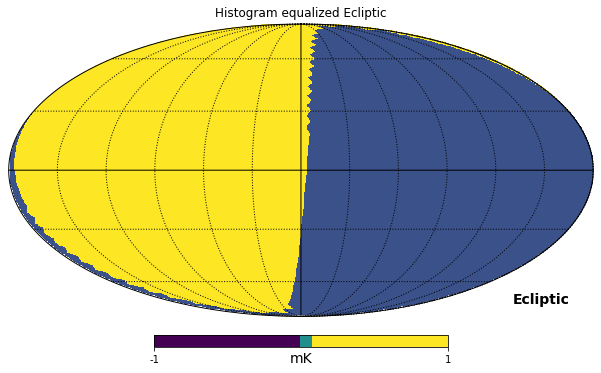

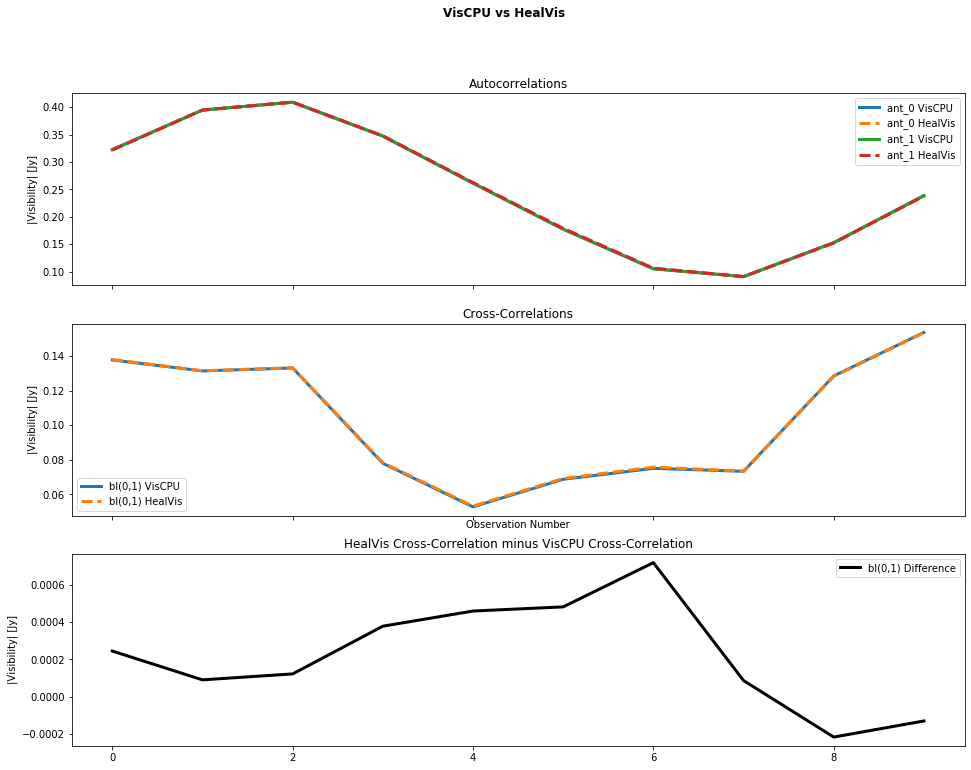

In [29]:
uvdata = myuvdata(ntel=2, ntimes=10)
uvdata1 = myuvdata(ntel=2, ntimes=10)
freqs = np.unique(uvdata.freq_array)
nbase = 4
nside = 2**nbase

I_sky = create_uniform_sky(nbase=nbase, scale=1)
npix = I_sky[0].shape[0]

vec = healpy.ang2vec(np.pi/2, 0)
ipix_disc = healpy.query_disc(nside=nside, vec=vec, radius=np.pi/2)
for i in range(len(freqs)):
    I_sky[i][ipix_disc] = 0
healpy.mollview(
    I_sky[3],
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="mK",
    norm="hist",
    min=-1,
    max=1,
)
healpy.graticule()

viscpu_sim = VisCPU(
    uvdata=uvdata1,
    sky_freqs=freqs,
    sky_intensity=I_sky,
    nside=nside
)

healvis_sim = HealVis(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=I_sky,
    nside=nside
)

viscpu_sim.simulate()
healvis_sim.simulate()

viscpu = viscpu_sim.uvdata.data_array
healvis = healvis_sim.uvdata.data_array

compare_blts(viscpu_sim, healvis_sim)

### 2 Telescope Point Source at Zenith


Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 2, Elapsed 0.03min, Remain 0.052hour, MaxRSS 0.212832GB
Finished: 1, Elapsed 0.03min, Remain 0.104hour, MaxRSS 0.168556GB
Finished: 3, Elapsed 0.03min, Remain 0.034hour, MaxRSS 0.212832GB
Finished: 4, Elapsed 0.03min, Remain 0.026hour, MaxRSS 0.212832GB
Finished: 5, Elapsed 0.03min, Remain 0.021hour, MaxRSS 0.212832GB
Finished: 6, Elapsed 0.03min, Remain 0.017hour, MaxRSS 0.212832GB
Finished: 7, Elapsed 0.03min, Remain 0.015hour, MaxRSS 0.212832GB
Finished: 8, Elapsed 0.03min, Remain 0.013hour, MaxRSS 0.212832GB
Finished: 9, Elapsed 0.03min, Remain 0.011hour, MaxRSS 0.212832GB
Finished: 10, Elapsed 0.03min, Remain 0.010hour, MaxRSS 0.212832GB
Finished: 11, Elapsed 0.03min, Remain 0.009hour, MaxRSS 0.212832GB
Finished: 12, Elapsed 0.03min, Remain 0.008hour, MaxRSS 0.212832GB
Finished: 13, Elapsed 0.03min, Remain 0.008hour, MaxRSS 0.212832GB
Finished: 14, Elapsed 0.03min, Remain 0.007hour, MaxRSS 0.212832GB
Finished: 15, Elapsed 0.03min, Remain 0.007hour, MaxRSS 0.212832GB
Fini

Finished: 124, Elapsed 0.04min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 125, Elapsed 0.04min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 126, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 127, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 128, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 129, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 130, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 131, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 132, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 133, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 134, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 135, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 136, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 137, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.21284GB
Finished: 138, Elapsed 0.05min, Remain 0.000hour, MaxRSS 0.212

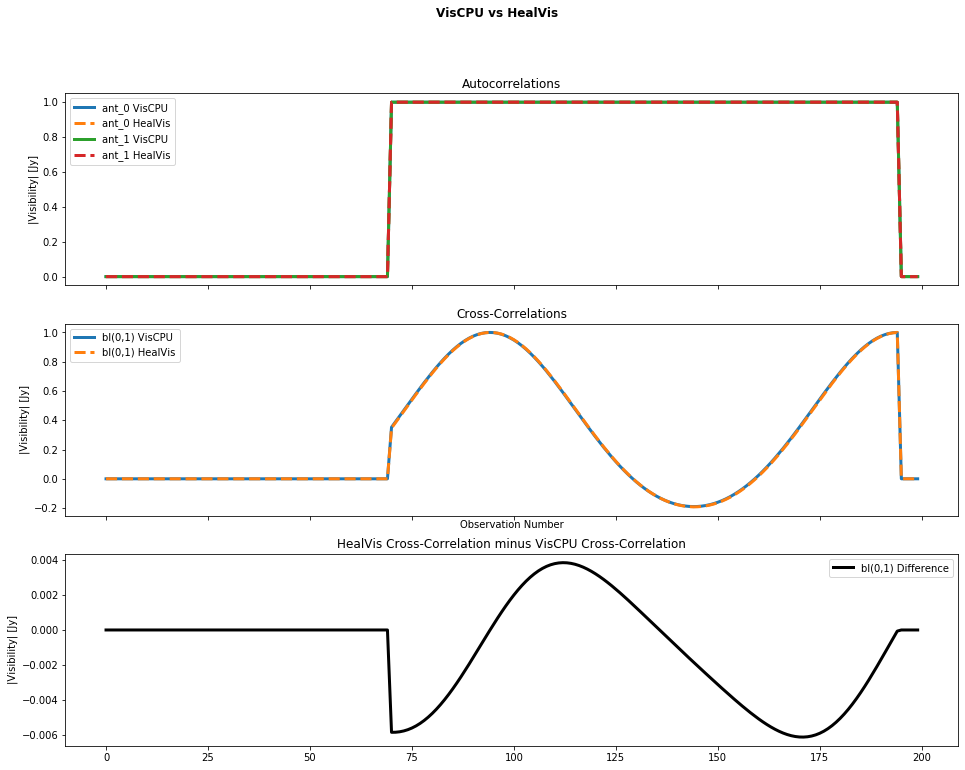

In [15]:
uvdata = myuvdata(ntel=2, ntimes=200)
uvdata1 = myuvdata(ntel=2, ntimes=200)
freqs = np.unique(uvdata.freq_array)
nside = 2**4

point_source_pos = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
point_source_flux = np.array([[1.0]] * len(freqs))

point_source_pos1, point_source_flux1 = align_src_to_healpix(point_source_pos, point_source_flux, nside=nside)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=point_source_pos1,
    point_source_flux=point_source_flux1,
    nside=nside
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_pos=point_source_pos1,
    point_source_flux=point_source_flux1,
    nside=nside
)

viscpu_sim.simulate()
healvis_sim.simulate()

viscpu = viscpu_sim.uvdata.data_array
healvis = healvis_sim.uvdata.data_array

compare_blts(viscpu_sim, healvis_sim)

### 2 Telescope 2 Point Sources


Compilation is falling back to object mode WITH looplifting enabled because Function "make_fringe" failed type inference due to: Use of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

[1] During: typing of get attribute at /home/jackson/hera/hera_sim/healvis/healvis/observatory.py (42)

File "../../../healvis/healvis/observatory.py", line 42:
def make_fringe(az, za, freq, enu):
    <source elided>
    uvw = np.outer(enu, 1 / (c_ms / freq))  # In wavelengths
    udotl = np.einsum("jk,jl->kl", lmn, uvw)
    ^

Function "make_fringe" was compiled in object mode without forceobj=True.

File "../../../healvis/healvis/observatory.py", line 31:
@jit
def make_fringe(az, za, freq, enu):
^


Fall-back from the nopython compilation path to the

Finished: 1, Elapsed 0.03min, Remain 0.004hour, MaxRSS 0.156932GB
Finished: 2, Elapsed 0.03min, Remain 0.002hour, MaxRSS 0.204456GB
Finished: 3, Elapsed 0.03min, Remain 0.001hour, MaxRSS 0.204456GB
Finished: 4, Elapsed 0.03min, Remain 0.001hour, MaxRSS 0.204456GB
Finished: 5, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.204456GB
Finished: 6, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.204456GB
Finished: 7, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.204456GB
Finished: 8, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.204456GB
Finished: 9, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.204456GB
Finished: 10, Elapsed 0.03min, Remain 0.000hour, MaxRSS 0.204456GB


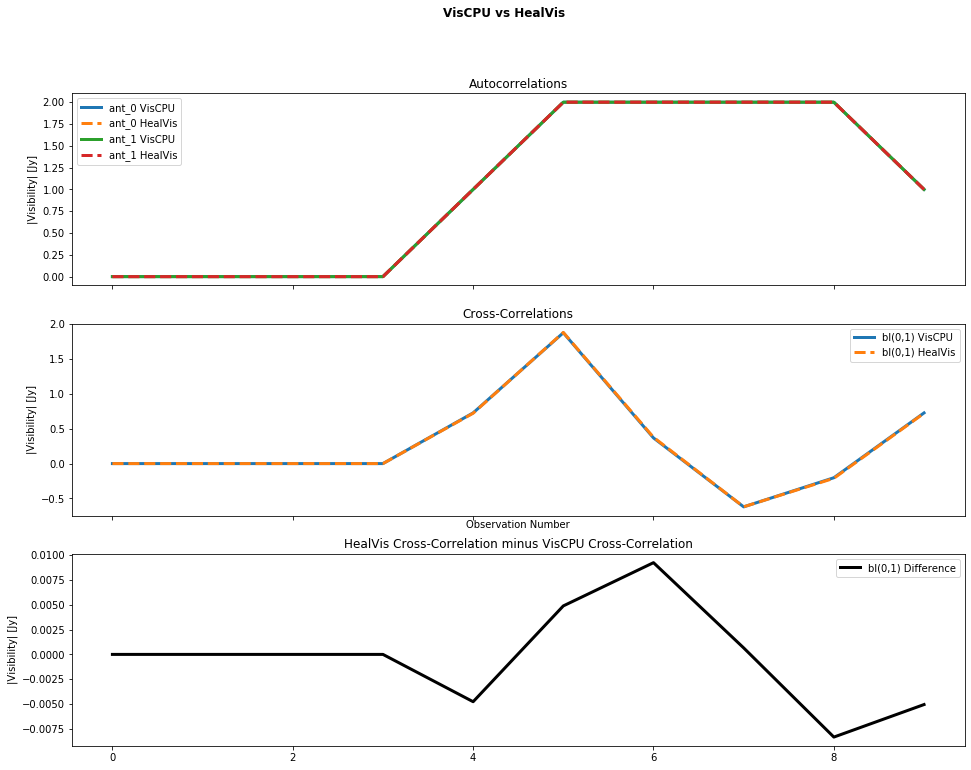

In [8]:
uvdata = myuvdata(ntel=2, ntimes=10)
uvdata1 = myuvdata(ntel=2, ntimes=10)
freqs = np.unique(uvdata.freq_array)

nside = 2 ** 4

# put a point source in
point_source_pos = np.array([[0, uvdata.telescope_location_lat_lon_alt[0] + np.pi/4],
                             [0, uvdata.telescope_location_lat_lon_alt[0]]])
point_source_flux = np.array([[1, 1]] * len(freqs))

# align to healpix center for direct comparision
point_source_pos, point_source_flux = align_src_to_healpix(point_source_pos, point_source_flux, nside=nside)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_flux=point_source_flux,
    point_source_pos=point_source_pos,
    nside=nside
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_flux=point_source_flux,
    point_source_pos=point_source_pos,
    nside=nside
)

viscpu_sim.simulate()
healvis_sim.simulate()

viscpu = viscpu_sim.uvdata.data_array
healvis = healvis_sim.uvdata.data_array

compare_blts(viscpu_sim, healvis_sim)